# Entrenamiento de Modelos de Machine Learning

Este notebook se centrará en transformar nuestros datos preprocesados en modelos predictivos y de clasificación robustos. Nuestro objetivo es entrenar y optimizar algoritmos que puedan predecir tendencias energéticas futuras, identificar países líderes en la transición y desentrañar las relaciones complejas entre variables energéticas.

## 1. Configuraciones del Entorno de Trabajo y Rutas

* Importación de Librerias

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
import xgboost as xgb # Una excelente opción para regresión y clasificación
from prophet import Prophet # Para modelos de series temporales
from prophet.plot import add_changepoints_to_plot
import joblib # Para guardar y cargar modelos
import warnings

* Importación de Funciones Personalizadas

In [30]:
import sys
import os
sys.path.append(os.path.abspath('..'))
import src.modelado as mod
import src.visualizacion as vis
import src.preprocesamiento as pre

* Configuración Global

In [31]:
# Para suprimir advertencias
warnings.filterwarnings("ignore")

# Configuración de Pandas para una mejor visualización de DataFrames
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_rows', 50)

# Configuración de NumPy para una salida más limpia
np.set_printoptions(precision=2, suppress=True)

# Configuración de Matplotlib
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12


# Configuración de Seaborn
sns.set_style('whitegrid')
sns.set_palette('deep')

# Configuración de Scikit-learn

tscv = TimeSeriesSplit(n_splits=5)
rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
xgb_params = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}

# Configuración de Prophet
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)

* Rutas

In [32]:
data_path = os.path.join('..', 'data', 'procesados', 'global_energy_consumption_features.csv')

* Carga del Dataset Limpio y Procesado

In [33]:
df = pre.cargar_datos(data_path)

## 2. Segmentación del Dataset para Modelos de Series Temporales, Regresión y Clasificación

### 2.1. Problema 1: Predicción de Series Temporales

Utilizaremos Prophet para estas predicciones, ya que es robusto para datos con estacionalidad y tendencias.

* Preparación para Prophet (Series Temporales)

In [34]:
# Creando un DataFrame para Prophet 'ds' son las fechas y 'y' es el consumo total de energía
df_prophet_total = df.groupby(['Country', 'Year'])['Total Energy Consumption (TWh)'].mean().reset_index()
df_prophet_total.rename(columns={'Year': 'ds', 'Total Energy Consumption (TWh)': 'y'}, inplace=True)

# Convirtiendo 'ds' a tipo datetime
df_prophet_total['ds'] = pd.to_datetime(df_prophet_total['ds'], format='%Y')

# Para el consumo per cápita
df_prophet_per_capita = df.groupby(['Country', 'Year'])['Per Capita Energy Use (kWh)'].mean().reset_index()
df_prophet_per_capita.rename(columns={'Year': 'ds', 'Per Capita Energy Use (kWh)': 'y'}, inplace=True)

# Convirtiendo 'ds' a tipo datetime
df_prophet_per_capita['ds'] = pd.to_datetime(df_prophet_per_capita['ds'], format='%Y')

### 2.2. Problema 2: Regresión

Aquí prepararemos los datos para predecir variables numéricas como `Carbon Emissions`.

* Selección de características (quitando las columnas que son de interés para otros modelos)

In [35]:
caracteristicas_base = [col for col in df.columns if col not in [
    'Country', 'Year',
    'Total Energy Consumption (TWh)', 'Per Capita Energy Use (kWh)',
    'Renewable Energy Share (%)']]

* Asegurar inclusión de columnas codificadas One-Hot de Country

In [36]:
country_one_hot_cols = [col for col in df.columns if col.startswith('Country_')]


* Crear el conjunto final de características (`caracteristicas_regresion`)

In [37]:
caracteristicas_regresion = [col for col in caracteristicas_base if col not in country_one_hot_cols] + country_one_hot_cols

In [38]:
caracteristicas_regresion

['Fossil Fuel Dependency (%)',
 'Carbon Emissions (Million Tons)',
 'Energy Price Index (USD/kWh)',
 'Industrial Energy Use (%)',
 'Household Energy Use (%)',
 'Tasa Anual Total Energy Consumption (TWh)',
 'Tasa Anual Per Capita Energy Use (kWh)',
 'Tasa Anual Carbon Emissions (Million Tons)',
 'renewable_fossil_ratio',
 'energy_efficiency',
 'fossil_total_ratio',
 'price_emissions_ratio',
 'Country_Australia',
 'Country_Brazil',
 'Country_Canada',
 'Country_China',
 'Country_Germany',
 'Country_India',
 'Country_Japan',
 'Country_Russia',
 'Country_UK',
 'Country_USA']

* Definir la variable objetivo

In [39]:
variable_objetivo = 'Carbon Emissions (Million Tons)'

* Crear `X_reg` y `y_reg` (caracteristicas y variable objetivo)

    * `X_reg`: contiene todas las columnas seleccionadas como caracteristicas, sin incluir la variable objetivo.

    * `y_reg`: contiene solo la variable objetivo.

In [40]:
X_reg = df[caracteristicas_regresion].drop(columns=[variable_objetivo], errors='ignore')
y_reg = df[variable_objetivo]


* Dividir los datos en entrenamiento y prueba (80% para entrenamiento y 20% para prueba)

In [41]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=22
)

* Mostrar resultados

In [42]:
print(f"\nCaracterísticas de regresión (X_reg.columns): {X_reg.columns.tolist()}")
print(f"Variable objetivo de regresión (y_reg.name): {y_reg.name}")
print(f"Dimensiones de X_train_reg: {X_train_reg.shape}")


Características de regresión (X_reg.columns): ['Fossil Fuel Dependency (%)', 'Energy Price Index (USD/kWh)', 'Industrial Energy Use (%)', 'Household Energy Use (%)', 'Tasa Anual Total Energy Consumption (TWh)', 'Tasa Anual Per Capita Energy Use (kWh)', 'Tasa Anual Carbon Emissions (Million Tons)', 'renewable_fossil_ratio', 'energy_efficiency', 'fossil_total_ratio', 'price_emissions_ratio', 'Country_Australia', 'Country_Brazil', 'Country_Canada', 'Country_China', 'Country_Germany', 'Country_India', 'Country_Japan', 'Country_Russia', 'Country_UK', 'Country_USA']
Variable objetivo de regresión (y_reg.name): Carbon Emissions (Million Tons)
Dimensiones de X_train_reg: (8000, 21)


### 2.3. Problema 3: Clasificación

Aquí crearemos una variable binaria y prepararemos los datos para clasificación.

* Crear la variable objetivo binaria

In [43]:
df['high_renewable_adoption'] = (df['Renewable Energy Share (%)'] > 50).astype(int)

* Definir la variable objetivo para clasificación

In [44]:
variable_objetivo_clasificacion = 'high_renewable_adoption'

* Definir las características (X) para clasificación

In [45]:
caracteristicas_clasificacion = [col for col in caracteristicas_regresion if col != 'Renewable Energy Share (%)']

* Definir X (features) e y (target)

In [46]:
X_cls = df[caracteristicas_clasificacion].drop(columns=[variable_objetivo_clasificacion], errors='ignore')
y_cls = df[variable_objetivo_clasificacion]


* División del dataset en entrenamiento y prueba (80% para entrenamiento y 20% para prueba)

In [47]:
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

* Mostrar resultados

In [48]:
print(f"\nCaracterísticas de clasificación (X_cls.columns): {X_cls.columns.tolist()}")
print(f"Variable objetivo de clasificación (y_cls.name): {y_cls.name}")
print(f"Dimensiones de X_train_cls: {X_train_cls.shape}")


Características de clasificación (X_cls.columns): ['Fossil Fuel Dependency (%)', 'Carbon Emissions (Million Tons)', 'Energy Price Index (USD/kWh)', 'Industrial Energy Use (%)', 'Household Energy Use (%)', 'Tasa Anual Total Energy Consumption (TWh)', 'Tasa Anual Per Capita Energy Use (kWh)', 'Tasa Anual Carbon Emissions (Million Tons)', 'renewable_fossil_ratio', 'energy_efficiency', 'fossil_total_ratio', 'price_emissions_ratio', 'Country_Australia', 'Country_Brazil', 'Country_Canada', 'Country_China', 'Country_Germany', 'Country_India', 'Country_Japan', 'Country_Russia', 'Country_UK', 'Country_USA']
Variable objetivo de clasificación (y_cls.name): high_renewable_adoption
Dimensiones de X_train_cls: (8000, 22)


## 3. Entrenamiento y Optimización de Modelos

Aquí entrenaremos modelos base y luego usaremos `GridSearchCV` para la optimización de hiperparámetros.

* Crear un directorio para los modelos de Prophet

In [49]:
os.makedirs('../models/prophet_models', exist_ok=True)
os.makedirs('../outputs/prophet_forecasts', exist_ok=True)

### 3.1. Inicializar diccionarios y definir horizonte de predicción

In [50]:
prophet_models = {} # Diccionario para almacenar los modelos de Prophet por país
predicciones = {}
forecast_horizon_years = 7 # Número de años a predecir

* Entrenar Prophet para cada país

  Entrenando Prophet para Australia...


00:05:56 - cmdstanpy - INFO - Chain [1] start processing
00:05:56 - cmdstanpy - INFO - Chain [1] done processing


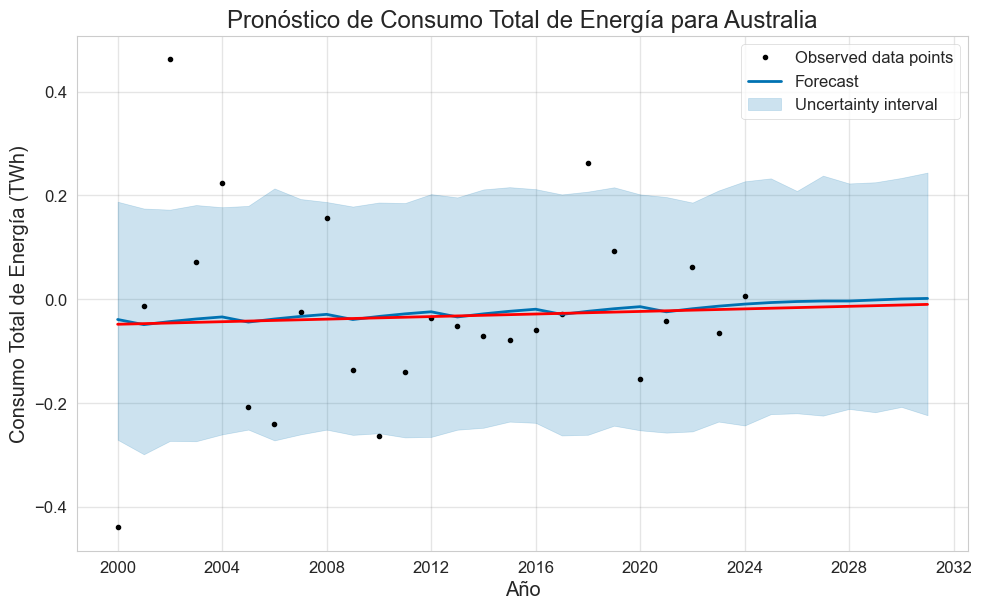

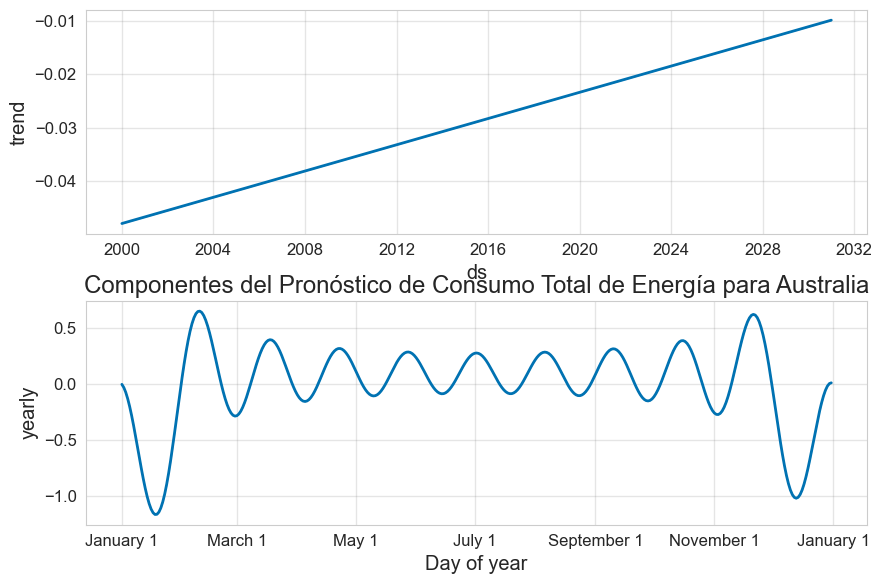

00:05:57 - cmdstanpy - INFO - Chain [1] start processing


  Entrenando Prophet para Brazil...


00:05:58 - cmdstanpy - INFO - Chain [1] done processing


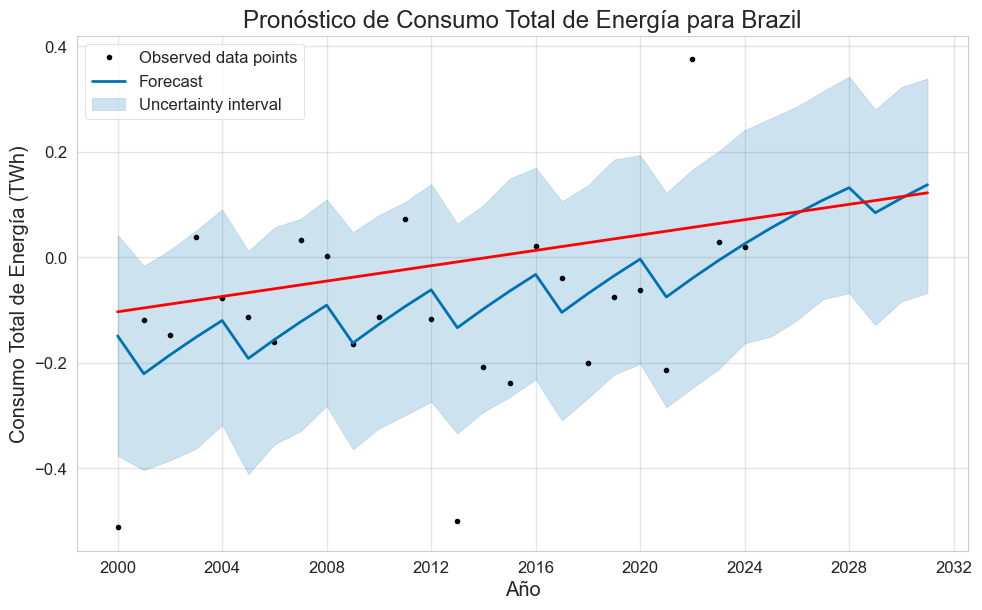

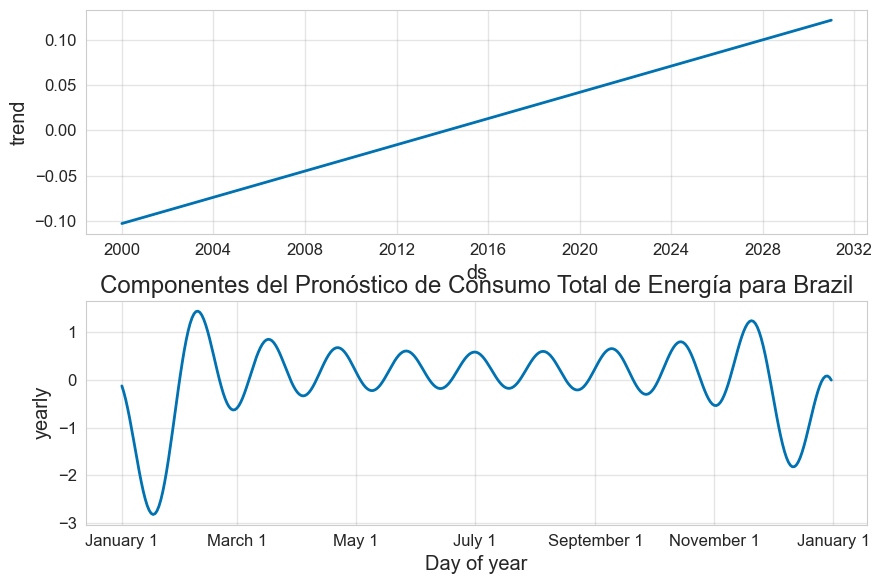

00:05:59 - cmdstanpy - INFO - Chain [1] start processing


  Entrenando Prophet para Canada...


00:05:59 - cmdstanpy - INFO - Chain [1] done processing


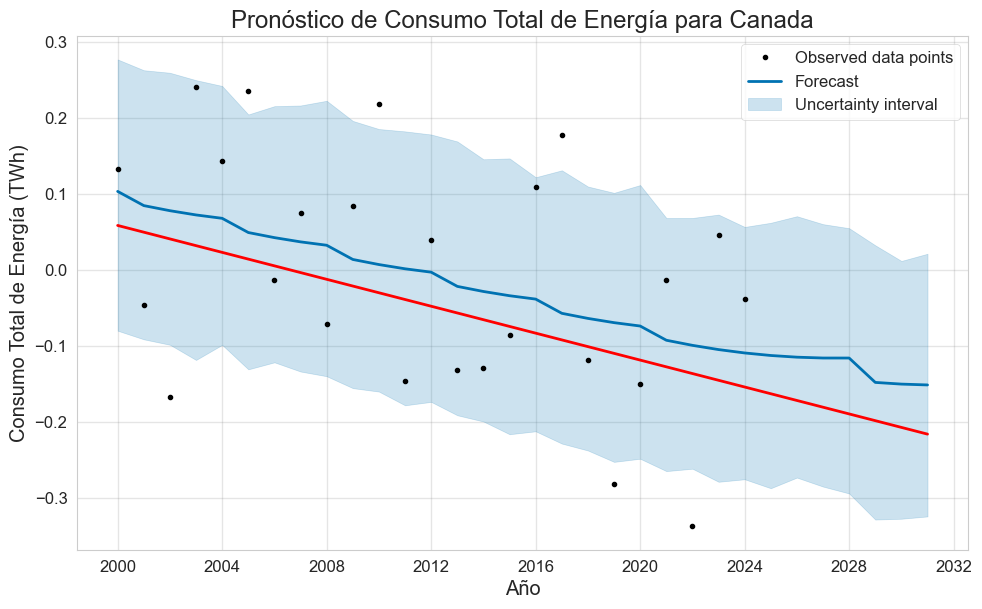

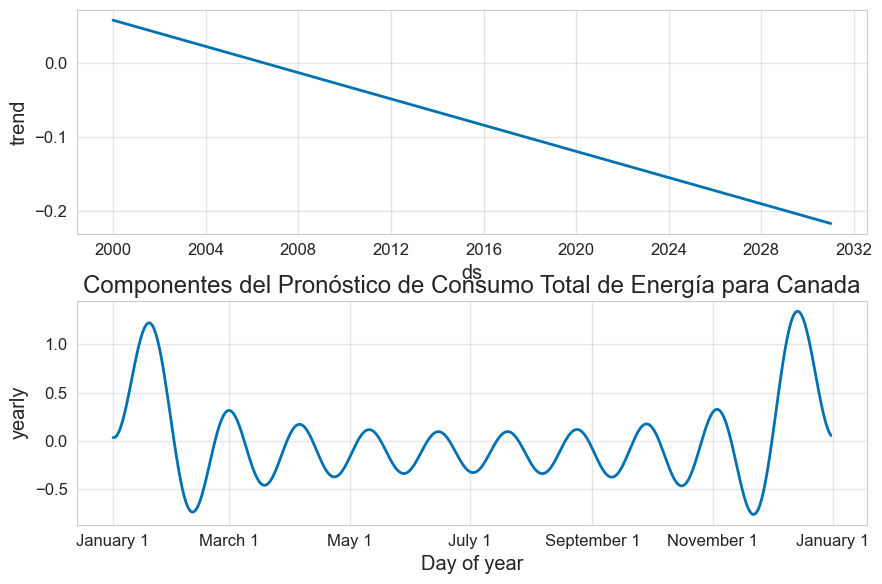

00:06:00 - cmdstanpy - INFO - Chain [1] start processing


  Entrenando Prophet para China...


00:06:01 - cmdstanpy - INFO - Chain [1] done processing


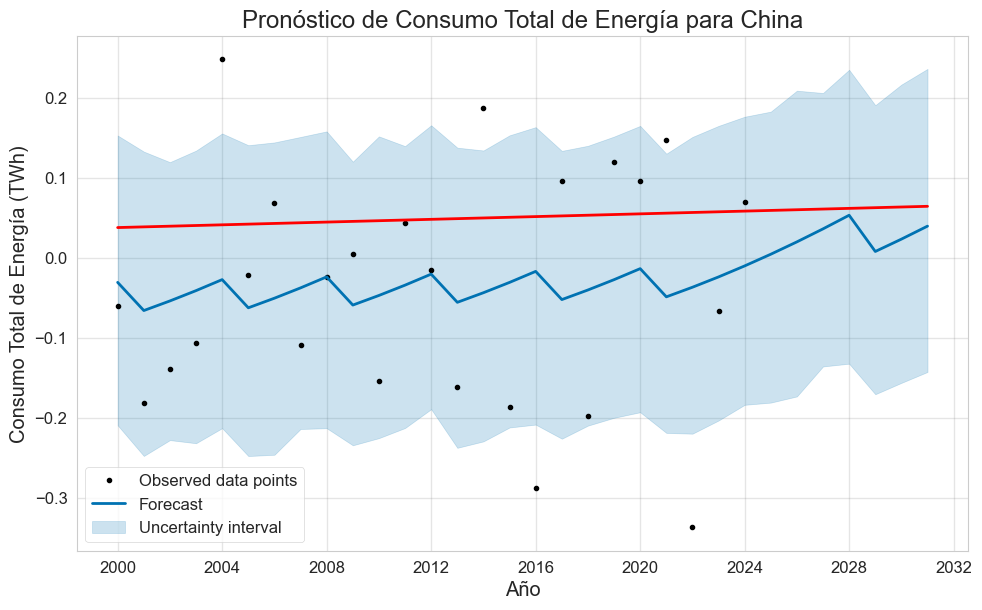

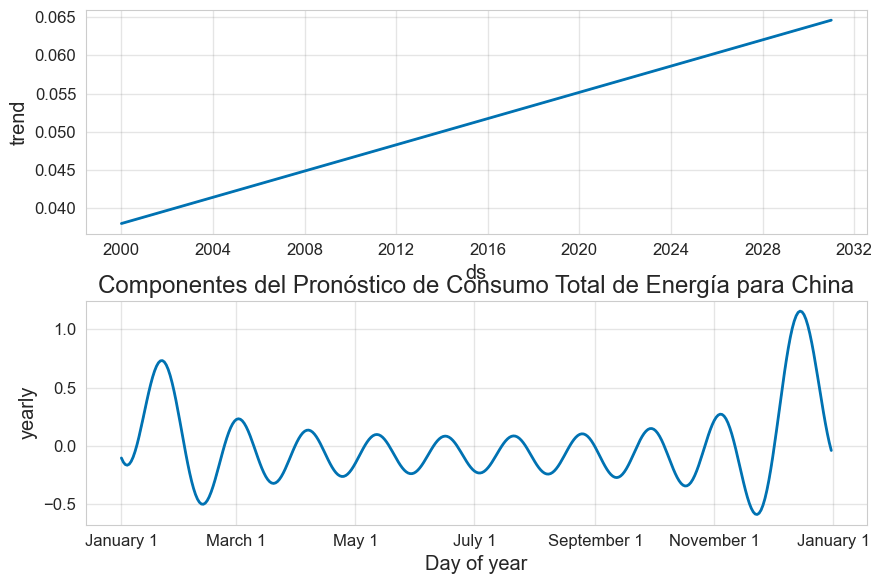

00:06:02 - cmdstanpy - INFO - Chain [1] start processing


  Entrenando Prophet para Germany...


00:06:02 - cmdstanpy - INFO - Chain [1] done processing


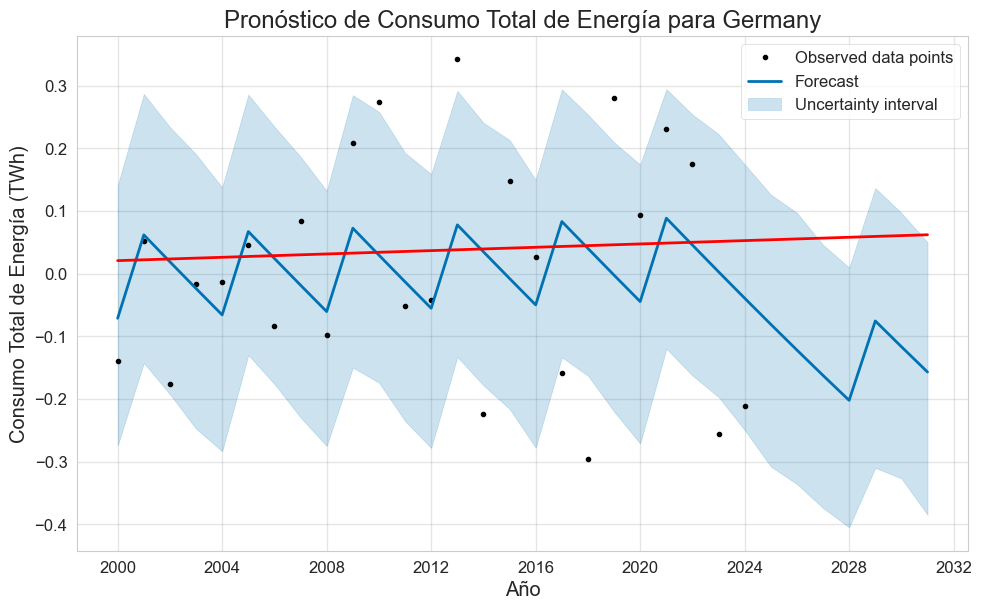

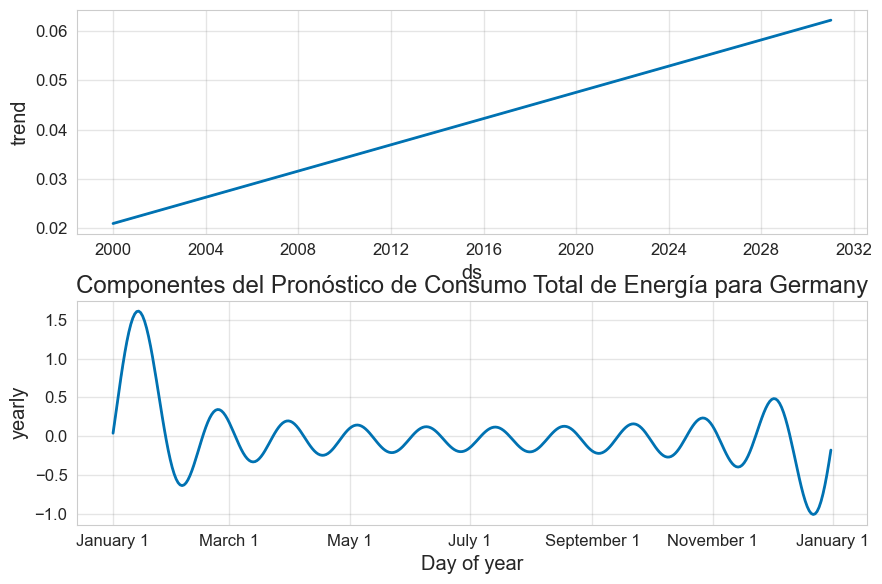

00:06:04 - cmdstanpy - INFO - Chain [1] start processing


  Entrenando Prophet para India...


00:06:04 - cmdstanpy - INFO - Chain [1] done processing


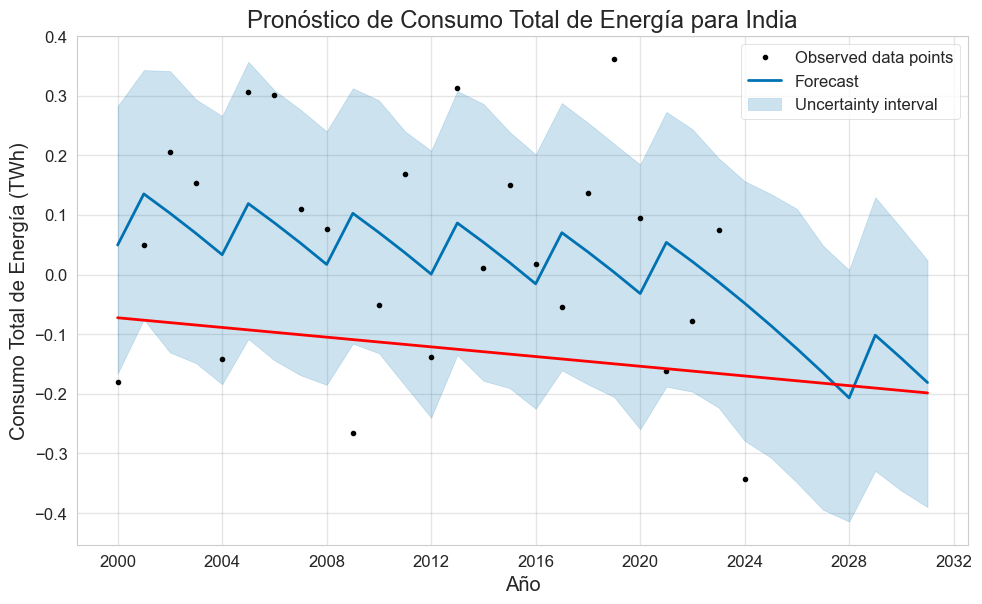

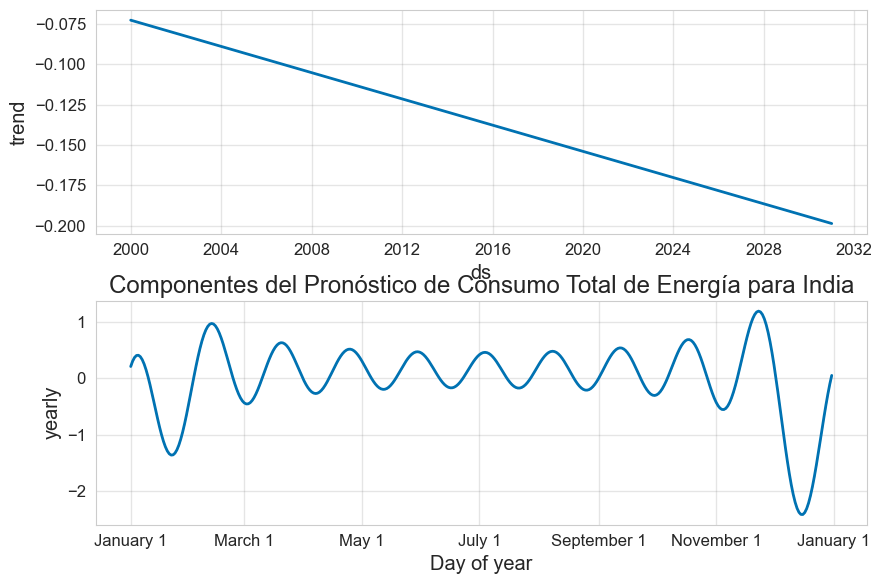

00:06:06 - cmdstanpy - INFO - Chain [1] start processing


  Entrenando Prophet para Japan...


00:06:06 - cmdstanpy - INFO - Chain [1] done processing


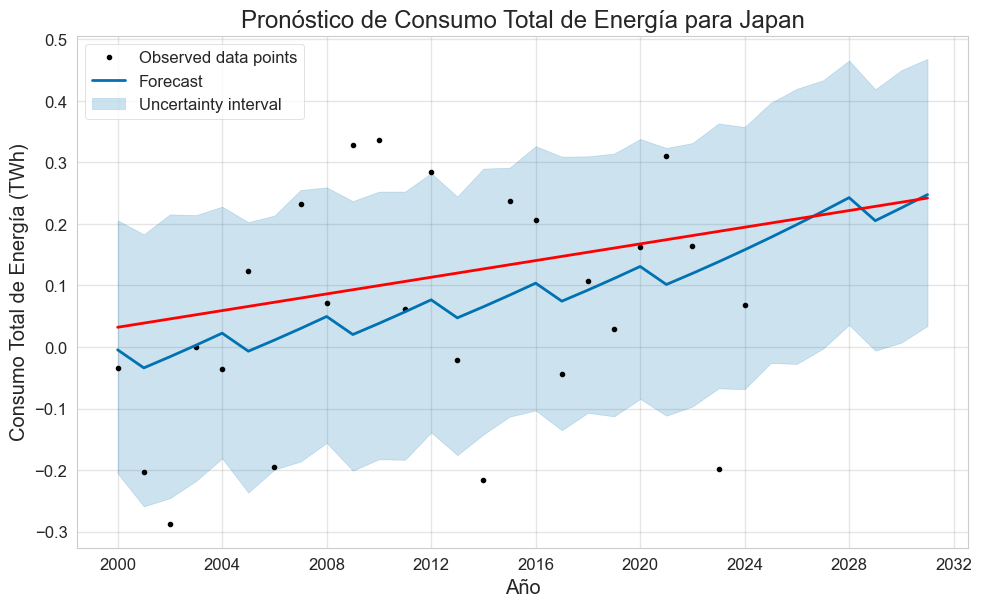

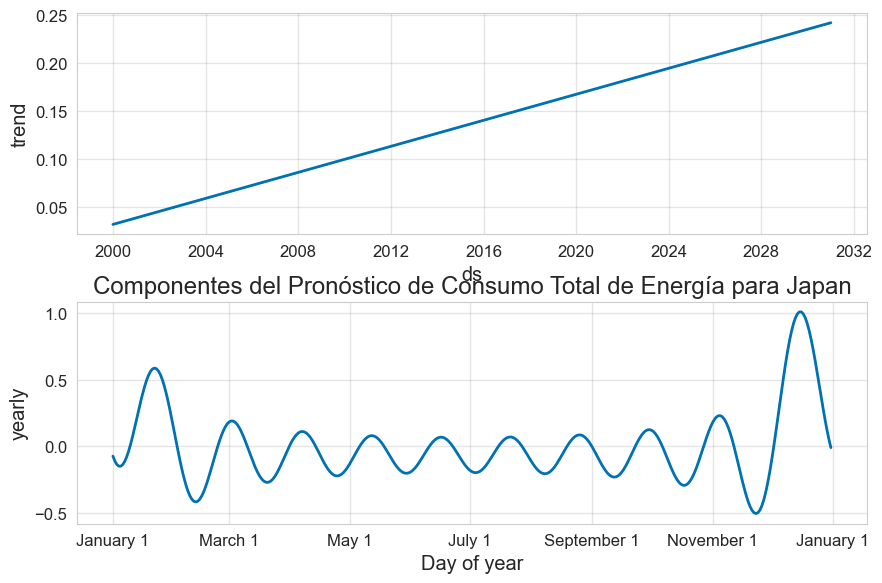

  Entrenando Prophet para Russia...


00:06:07 - cmdstanpy - INFO - Chain [1] start processing
00:06:07 - cmdstanpy - INFO - Chain [1] done processing


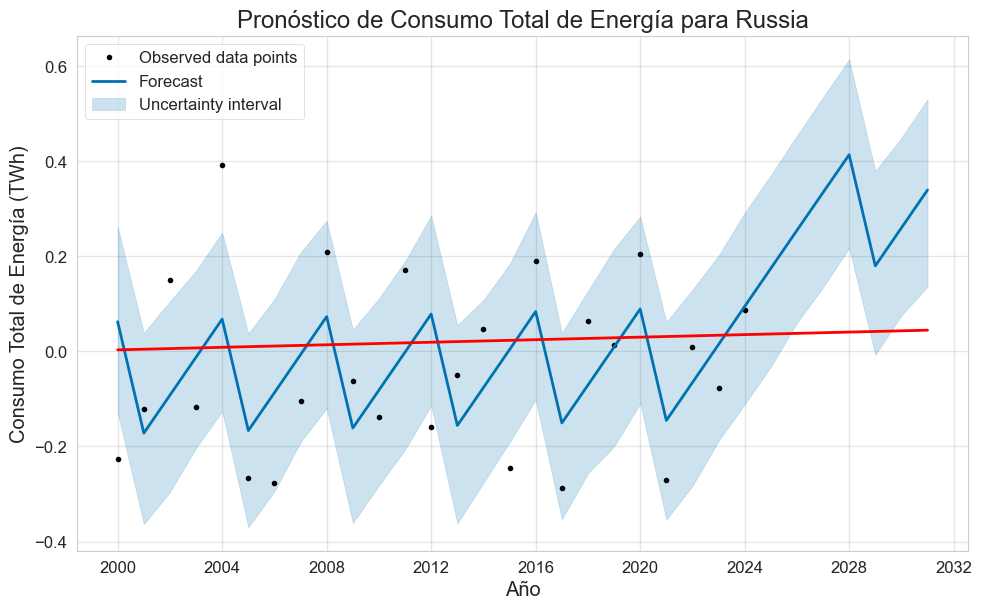

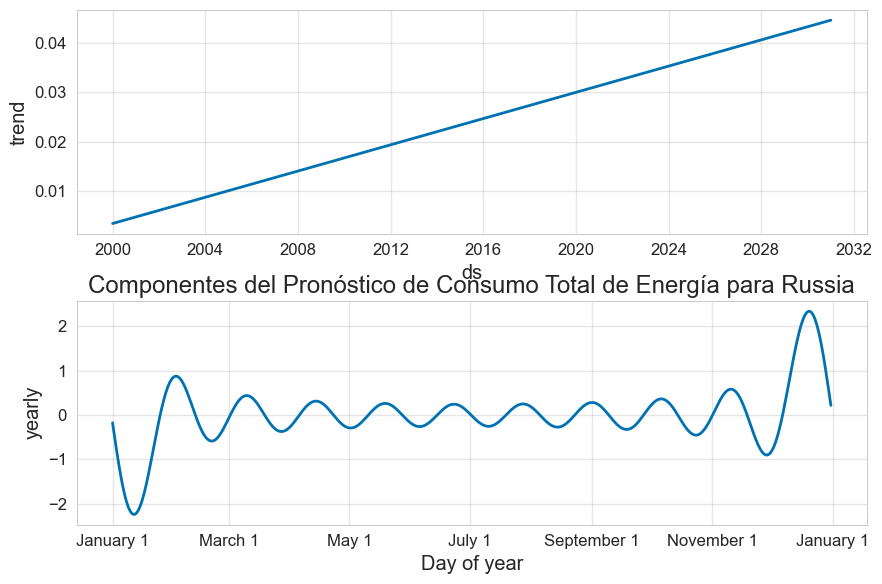

00:06:09 - cmdstanpy - INFO - Chain [1] start processing


  Entrenando Prophet para UK...


00:06:09 - cmdstanpy - INFO - Chain [1] done processing


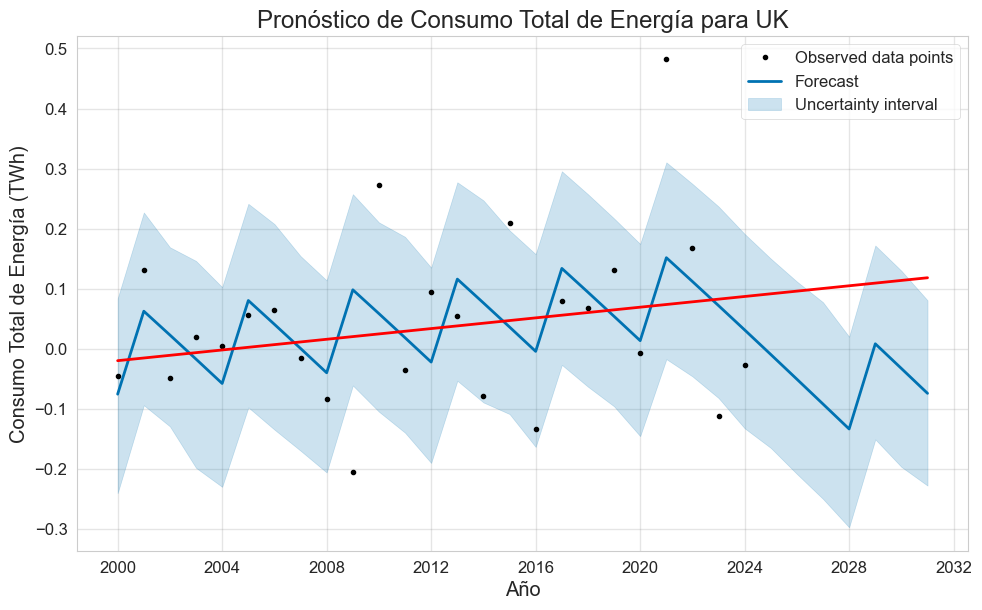

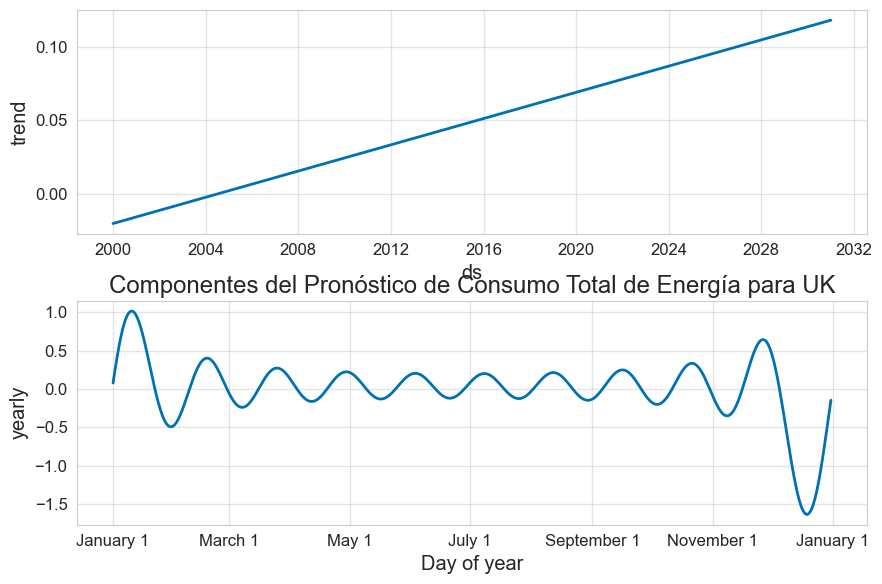

00:06:11 - cmdstanpy - INFO - Chain [1] start processing


  Entrenando Prophet para USA...


00:06:11 - cmdstanpy - INFO - Chain [1] done processing


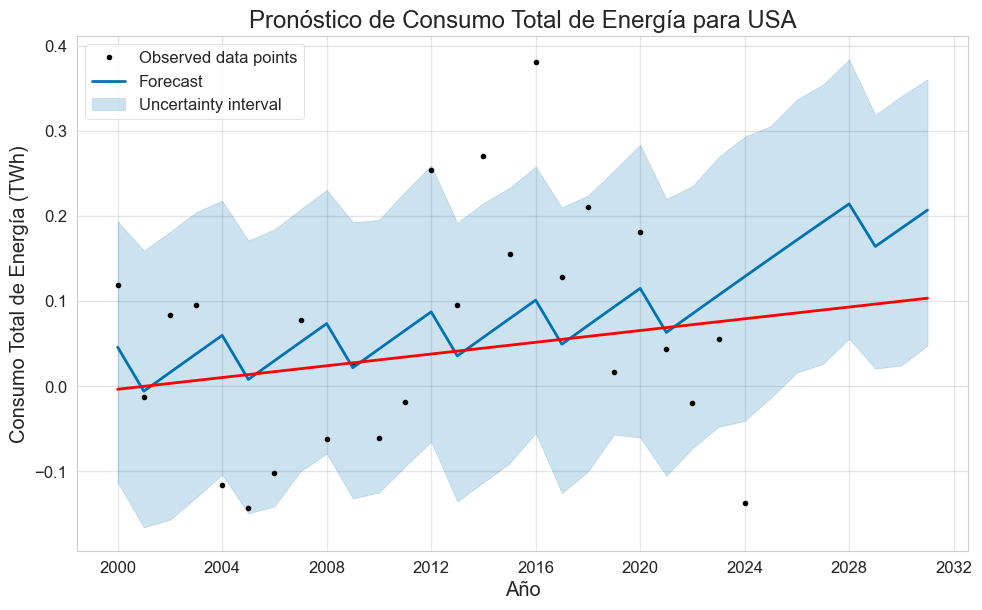

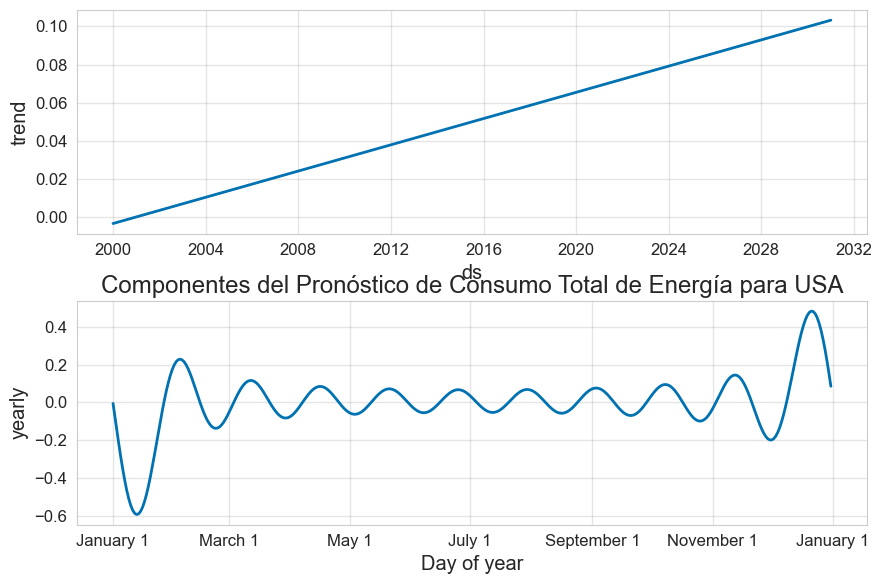

In [51]:
for country in df_prophet_total['Country'].unique():
    print(f"  Entrenando Prophet para {country}...")
    df_country = df_prophet_total[df_prophet_total['Country'] == country].copy()

    m = Prophet(seasonality_mode = 'additive',
                changepoint_prior_scale= 0.05,
                yearly_seasonality=True,
                weekly_seasonality=False,
                daily_seasonality=False)
    
    # Entrenar el modelo
    m.fit(df_country)
    prophet_models[country] = m

    # Crear un DataFrame para las predicciones
    future = m.make_future_dataframe(periods=forecast_horizon_years, freq='Y')

    prediccion = m.predict(future)
    predicciones[country] = prediccion

    # Visualizar las predicciones
    fig = m.plot(prediccion, include_legend=True)
    a = add_changepoints_to_plot(fig.gca(), m, prediccion)
    plt.title(f'Pronóstico de Consumo Total de Energía para {country}')
    plt.xlabel('Año')
    plt.ylabel('Consumo Total de Energía (TWh)')
    plt.savefig(f'../outputs/prophet_forecasts/prophet_forecast_total_energy_{country.replace(" ", "_")}.png', dpi=300)
    plt.show()
    plt.close(fig)

    # Visualizar los componentes (comportamiento estacional, tendencia, etc.)
    fig2 = m.plot_components(prediccion)
    plt.title(f'Componentes del Pronóstico de Consumo Total de Energía para {country}', )
    plt.savefig(f'../outputs/prophet_forecasts/prophet_components_total_energy_{country.replace(" ", "_")}.png', dpi=300)
    plt.show()
    plt.close(fig2)


In [52]:
prediccion

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-01-01,-0.00,-0.11,0.19,-0.00,-0.00,0.05,0.05,0.05,0.05,0.05,0.05,0.00,0.00,0.00,0.05
1,2001-01-01,-0.00,-0.17,0.16,-0.00,-0.00,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,0.00,0.00,0.00,-0.01
2,2002-01-01,0.00,-0.16,0.18,0.00,0.00,0.01,0.01,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.02
3,2003-01-01,0.01,-0.13,0.20,0.01,0.01,0.03,0.03,0.03,0.03,0.03,0.03,0.00,0.00,0.00,0.04
4,2004-01-01,0.01,-0.10,0.22,0.01,0.01,0.05,0.05,0.05,0.05,0.05,0.05,0.00,0.00,0.00,0.06
5,2005-01-01,0.01,-0.15,0.17,0.01,0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,0.00,0.00,0.00,0.01
6,2006-01-01,0.02,-0.14,0.18,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.03
7,2007-01-01,0.02,-0.10,0.21,0.02,0.02,0.03,0.03,0.03,0.03,0.03,0.03,0.00,0.00,0.00,0.05
8,2008-01-01,0.02,-0.08,0.23,0.02,0.02,0.05,0.05,0.05,0.05,0.05,0.05,0.00,0.00,0.00,0.07
9,2009-01-01,0.03,-0.13,0.19,0.03,0.03,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,0.00,0.00,0.00,0.02
